In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#!pip install -q torchvision
import torch
import torchvision
import torchvision.transforms as T
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import resnet50
import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2

# SEGMENTATION MODEL MASKRCNN

In [92]:
class LungTumorDataset(Dataset):
    def __init__(self, image_dir, detection_dir, mask_dir, transforms=None):
        self.image_paths = []
        self.label_paths = []
        self.mask_paths = []
        self.transforms = transforms

        subject_dirs = sorted(os.listdir(image_dir))
        for subject in subject_dirs:
            subject_img_dir = os.path.join(image_dir, subject)
            subject_lbl_dir = os.path.join(detection_dir, subject)
            subject_mask_dir = os.path.join(mask_dir, subject)

            for img_name in sorted(os.listdir(subject_img_dir)):
                img_path = os.path.join(subject_img_dir, img_name)
                label_name = os.path.splitext(img_name)[0] + ".txt"
                label_path = os.path.join(subject_lbl_dir, label_name)
                mask_path = os.path.join(subject_mask_dir, img_name)

                self.image_paths.append(img_path)
                self.label_paths.append(label_path)
                self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        #print(f"Loading index {idx}")
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        mask_path = self.mask_paths[idx]

        img = np.array(Image.open(img_path).convert("L"))  # grayscale uint8
        mask = np.array(Image.open(mask_path).convert("L"))  # combined mask uint8

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    x_min, y_min, x_max, y_max = map(float, parts)
                    boxes.append([x_min, y_min, x_max, y_max])

        labels_list = [1] * len(boxes)  # tumor class

        if self.transforms:
            # Albumentations requires mask list even if only one mask
            transformed = self.transforms(
                image=img,
                bboxes=boxes,
                masks=[mask],  # single combined mask in a list
                labels=labels_list
            )
            img = transformed['image']
            boxes = transformed['bboxes']
            mask = transformed['masks'][0]  # single combined mask after transform
            labels_list = transformed['labels']

        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels_list, dtype=torch.int64)
            # masks tensor shape: [1, H, W]
            masks = torch.as_tensor(np.expand_dims(mask, axis=0), dtype=torch.uint8)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, img.shape[1], img.shape[2]), dtype=torch.uint8)

        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).float() / 255.0
        elif isinstance(img, torch.Tensor) and img.dtype == torch.uint8:
            img = img.float() / 255.0

        if img.ndim == 2:
            img = img.unsqueeze(0)  # add channel dimension

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks  # single combined mask
        }

        return img, target, masks

# ... rest of your code for defining transforms and creating dataset/dataloader

In [ ]:
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.OneOf([
        A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), size=(256, 256), p=0.5),
        A.Resize(256, 256)
    ], p=1.0),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


def collate_fn(batch):
    return tuple(zip(*batch))

# Update these paths to your actual data locations in Google Drive
train_img_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/train/images'
train_detection_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/train/detections'
train_mask_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/train/masks'


train_dataset = LungTumorDataset(train_img_dir, train_detection_dir, train_mask_dir, transforms=albumentations_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn , num_workers=0 )
print("Dataset and DataLoader created successfully.")

Dataset and DataLoader created successfully.


C:\Users\mazen\AppData\Local\Temp\ipykernel_14884\1501587994.py:5: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), size=(256, 256), p=0.5),


In [ ]:
val_img_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/val/images'
val_detection_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/val/detections'
val_mask_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/val/masks'

val_dataset = LungTumorDataset(val_img_dir, val_detection_dir, val_mask_dir, transforms=albumentations_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn )

In [95]:
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Load model with pretrained COCO weights
model = maskrcnn_resnet50_fpn(pretrained=True)

# Replace the box + mask heads to match your dataset (1 class + background)
num_classes = 2  # 1 (tumor) + background
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features_box, num_classes
)

model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_features_mask, hidden_layer, num_classes
)


In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [97]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [103]:
import torch
from tqdm import tqdm

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    skipeed_empty = 0
    nan_losses = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    skipped_batches = 0

    pbar = tqdm(train_loader, desc="Training", leave=True)

    for batch_idx, (images, targets, masks) in enumerate(pbar):
        images = [img.to(device) for img in images]
        new_targets = []
        skip_batch = False

        for i, (tgt, m) in enumerate(zip(targets, masks)):
            tgt = {k: v.clone().detach().to(device) for k, v in tgt.items()}

            if tgt["boxes"].numel() == 0 or tgt["labels"].numel() == 0:
                skip_batch = True
                skipeed_empty += 1
                break

            H, W = images[0].shape[1:]
            tgt["boxes"][:, 0::2] = tgt["boxes"][:, 0::2].clamp(0, W - 1)
            tgt["boxes"][:, 1::2] = tgt["boxes"][:, 1::2].clamp(0, H - 1)

            if (tgt["labels"] < 1).any():
                skip_batch = True
                break
            tgt["labels"] = tgt["labels"].clamp(min=1)

            if m.ndim == 2:
                m = m.unsqueeze(0)
            m = (m > 0.5).float()

            if torch.isnan(m).any() or torch.isinf(m).any():
                skip_batch = True
                break

            tgt["masks"] = m.to(device)
            new_targets.append(tgt)

        if skip_batch:
            skipped_batches += 1
            pbar.set_description(f"Epoch {epoch+1} - Skipped batch {batch_idx+1}")
            continue

        try:
            loss_dict = model(images, new_targets)
            losses = sum(loss for loss in loss_dict.values())

            if torch.isnan(losses) or torch.isinf(losses):
                nan_losses += 1
                skipped_batches += 1
                pbar.set_description(f"Epoch {epoch+1} - NaN/Inf loss at batch {batch_idx+1}")
                continue

            if losses.item() < 1e-8:
                pbar.set_description(f"Epoch {epoch+1} - Near-zero loss at batch {batch_idx+1}")
                continue

            # Gradient step
            optimizer.zero_grad()
            losses.backward()

            # Gradient clipping to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            epoch_loss += losses.item()

            pbar.set_description(f"Epoch {epoch+1} - Batch {batch_idx+1} Loss: {losses.item():.4f}")

        except Exception as e:
            skipped_batches += 1
            pbar.set_description(f"Epoch {epoch+1} - Exception at batch {batch_idx+1}")
            continue

    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {epoch_loss:.4f}, Skipped Batches: {skipped_batches}, NaN/Skipped: {nan_losses}, empty/Skipped Batches: {skipeed_empty}")

    torch.save(model.state_dict(), f"maskrcnn_lungtumor_epoch{epoch+1}.pth")



Epoch 1/10


Training:   0%|          | 0/1832 [00:00<?, ?it/s]

C:\Users\mazen\AppData\Local\Temp\ipykernel_14884\692771950.py:61: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.as_tensor(labels_list, dtype=torch.int64)
Epoch 1 - Batch 1832 Loss: 0.3819: 100%|██████████| 1832/1832 [04:35<00:00,  6.65it/s]     


Epoch 1/10, Total Loss: 884.9557, Skipped Batches: 285, NaN/Skipped: 0, empty/Skipped Batches: 285

Epoch 2/10


Epoch 2 - Skipped batch 1832: 100%|██████████| 1832/1832 [04:25<00:00,  6.89it/s]       


Epoch 2/10, Total Loss: 1533.7745, Skipped Batches: 285, NaN/Skipped: 0, empty/Skipped Batches: 285

Epoch 3/10


Epoch 3 - Batch 1832 Loss: 0.3182: 100%|██████████| 1832/1832 [04:25<00:00,  6.90it/s]     


Epoch 3/10, Total Loss: 1358.8315, Skipped Batches: 285, NaN/Skipped: 0, empty/Skipped Batches: 285

Epoch 4/10


Epoch 4 - Batch 1832 Loss: 0.3432: 100%|██████████| 1832/1832 [05:00<00:00,  6.09it/s]     


Epoch 4/10, Total Loss: 1785.1558, Skipped Batches: 285, NaN/Skipped: 0, empty/Skipped Batches: 285

Epoch 5/10


Epoch 5 - Batch 1832 Loss: 0.1548: 100%|██████████| 1832/1832 [04:59<00:00,  6.12it/s]     


Epoch 5/10, Total Loss: 1090.3094, Skipped Batches: 285, NaN/Skipped: 0, empty/Skipped Batches: 285

Epoch 6/10


Epoch 6 - Batch 1832 Loss: 0.2766: 100%|██████████| 1832/1832 [04:46<00:00,  6.40it/s]


Epoch 6/10, Total Loss: 868.7298, Skipped Batches: 285, NaN/Skipped: 0, empty/Skipped Batches: 285

Epoch 7/10


Epoch 7 - Skipped batch 1832: 100%|██████████| 1832/1832 [04:44<00:00,  6.45it/s]        


Epoch 7/10, Total Loss: 1124.9559, Skipped Batches: 286, NaN/Skipped: 1, empty/Skipped Batches: 285

Epoch 8/10


Epoch 8 - Skipped batch 1832: 100%|██████████| 1832/1832 [04:32<00:00,  6.73it/s]     


Epoch 8/10, Total Loss: 876.4908, Skipped Batches: 285, NaN/Skipped: 0, empty/Skipped Batches: 285

Epoch 9/10


Epoch 9 - Skipped batch 1832: 100%|██████████| 1832/1832 [04:45<00:00,  6.41it/s]      


Epoch 9/10, Total Loss: 941.2708, Skipped Batches: 285, NaN/Skipped: 0, empty/Skipped Batches: 285

Epoch 10/10


Epoch 10 - Batch 1832 Loss: 0.4319: 100%|██████████| 1832/1832 [04:35<00:00,  6.65it/s]     


Epoch 10/10, Total Loss: 867.5983, Skipped Batches: 285, NaN/Skipped: 0, empty/Skipped Batches: 285


In [ ]:
import torch
import torch.nn.functional as F

def mask_iou(pred_mask, gt_mask):
    """Compute IoU between two binary masks."""
    intersection = (pred_mask & gt_mask).float().sum()
    union = (pred_mask | gt_mask).float().sum()
    if union == 0:
        return float('nan')
    return (intersection / union).item()

def calculate_segmentation_accuracy(model, data_loader, device):
    model.eval()
    total_ious = []
    a=0
    t=0
    with torch.no_grad():
        for images, targets, _ in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_masks = output.get("masks")  # shape: [N, 1, H, W]
                gt_masks = target.get("masks")    # shape: [M, H, W]

                if pred_masks is None or gt_masks is None or len(gt_masks) == 0:
                    continue

                pred_masks = (pred_masks > 0.5).squeeze(1)  # -> [N, H, W]
                pred_masks = pred_masks.to(device)
                gt_masks = (gt_masks > 0.5).to(torch.bool).to(device)

                matched_ious = []
                num_preds = pred_masks.shape[0]
                num_gts = gt_masks.shape[0]

                if num_preds == 0 or num_gts == 0:
                    continue

                # Compute IoUs between all predicted and ground truth masks
                for pred_idx in range(num_preds):
                    pred_mask = pred_masks[pred_idx]
                    best_iou = 0

                    for gt_idx in range(num_gts):
                        t += 1
                        gt_mask = gt_masks[gt_idx]
                        iou = mask_iou(pred_mask.bool(), gt_mask)
                        if not torch.isnan(torch.tensor(iou)) and iou > best_iou:
                            best_iou = iou

                    if best_iou > 0:  # only count meaningful matches
                        matched_ious.append(best_iou)
                        a += 1

                #total_ious.extend(matched_ious)

    # if total_ious:
    #     mean_iou = sum(total_ious) / len(total_ious)
    # else:
        # mean_iou = 0.0
    
    #print(f"Total masks: {t}, Matched masks: {a}")

    return a/t

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

mean_mask_iou = calculate_segmentation_accuracy(model, val_loader, device)
print(f"Mean mask IoU on validation set: {mean_mask_iou:.4f}")


C:\Users\mazen\AppData\Local\Temp\ipykernel_14884\692771950.py:61: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.as_tensor(labels_list, dtype=torch.int64)


Mean mask IoU on validation set: 0.8462


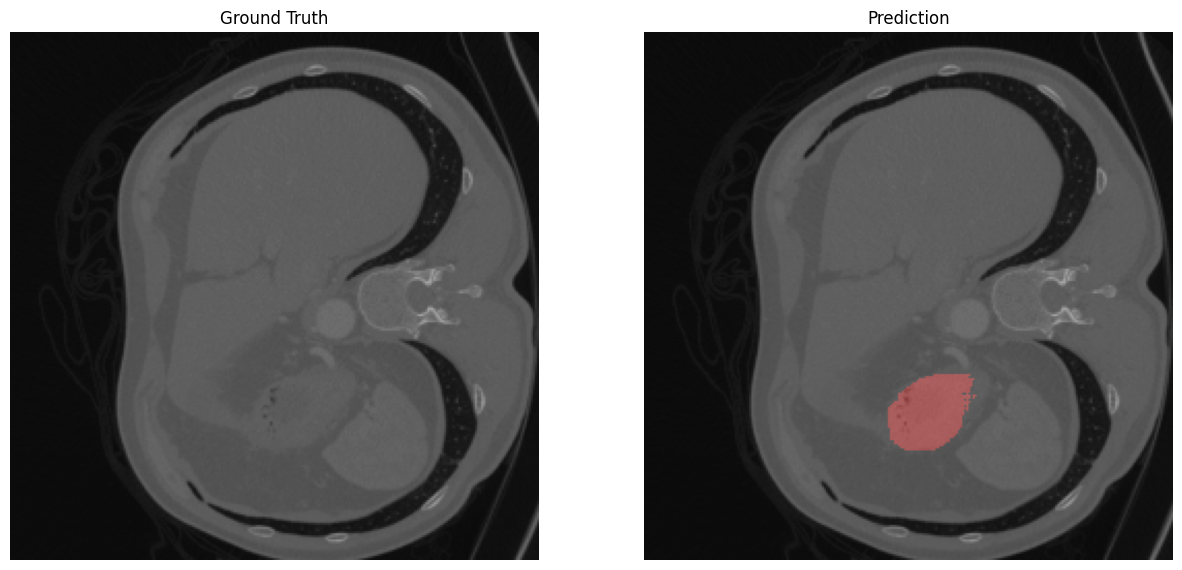

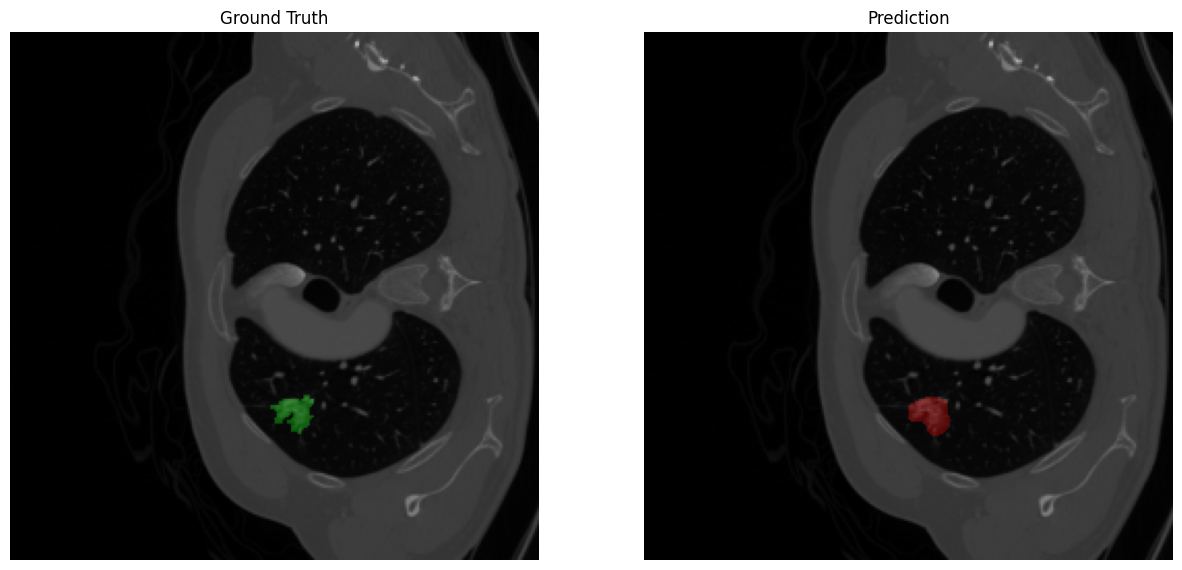

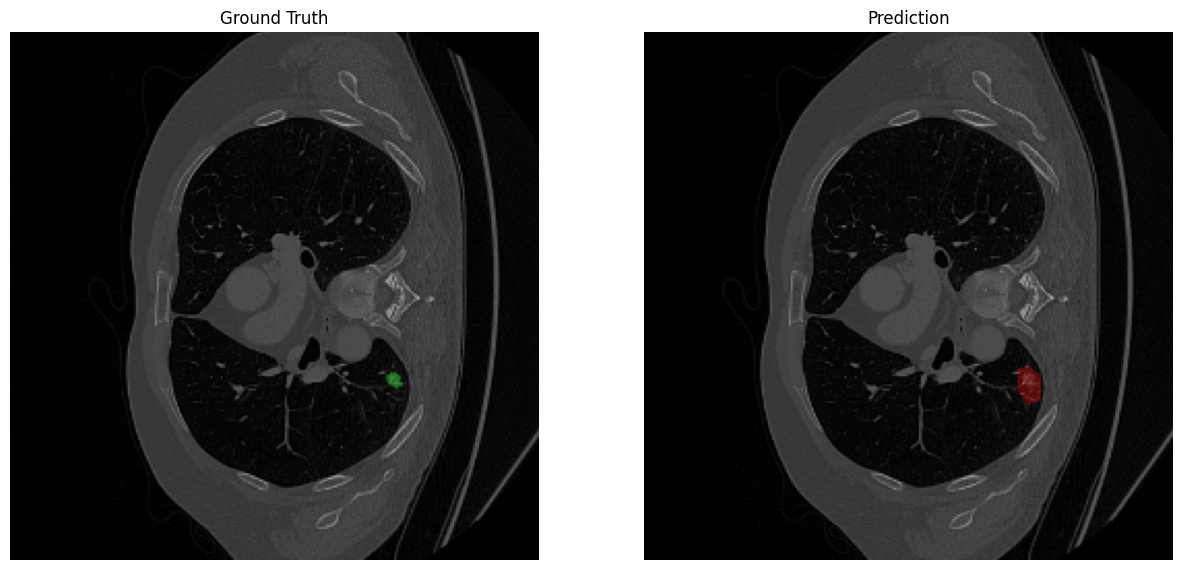

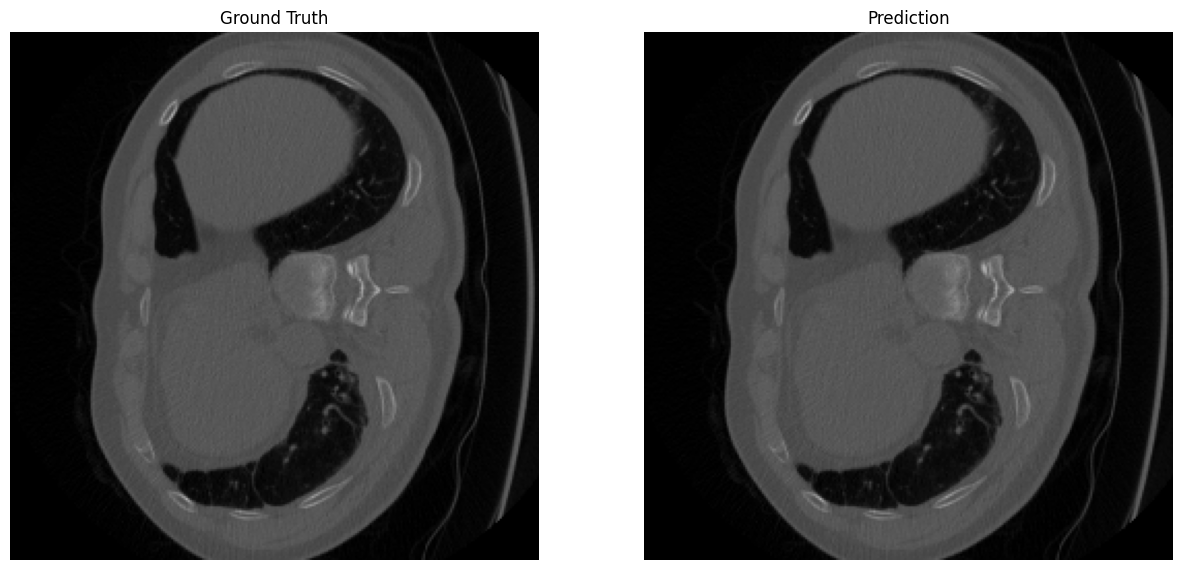

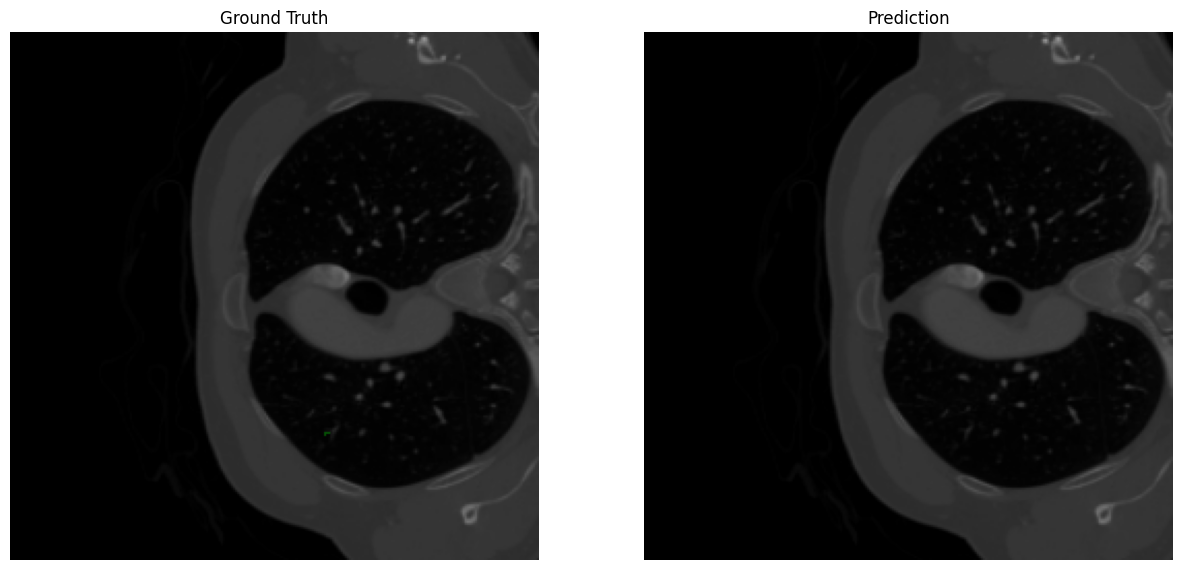

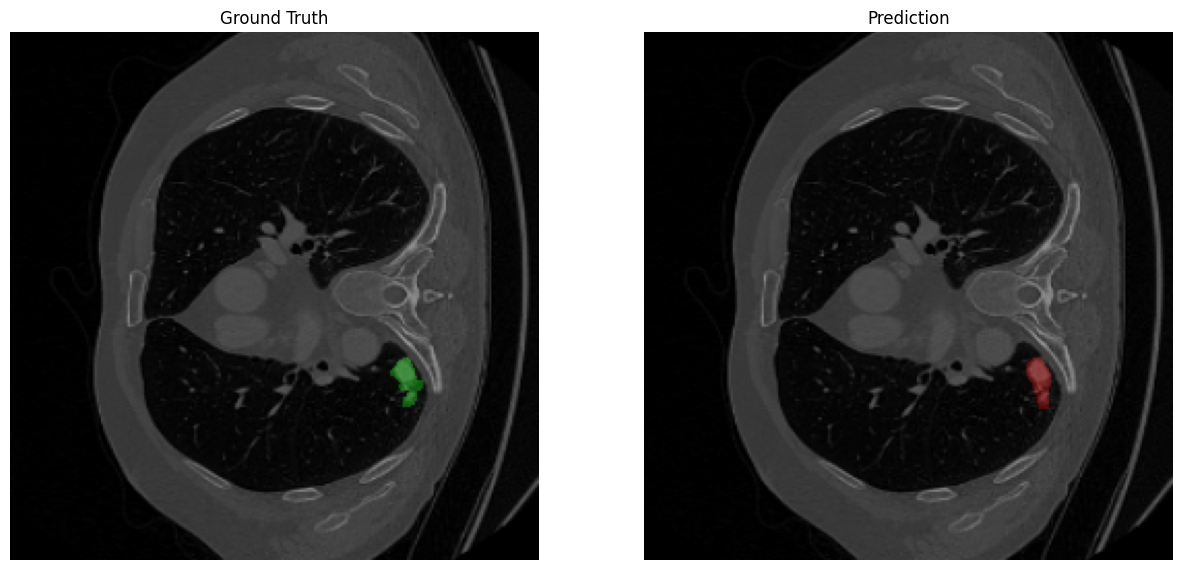

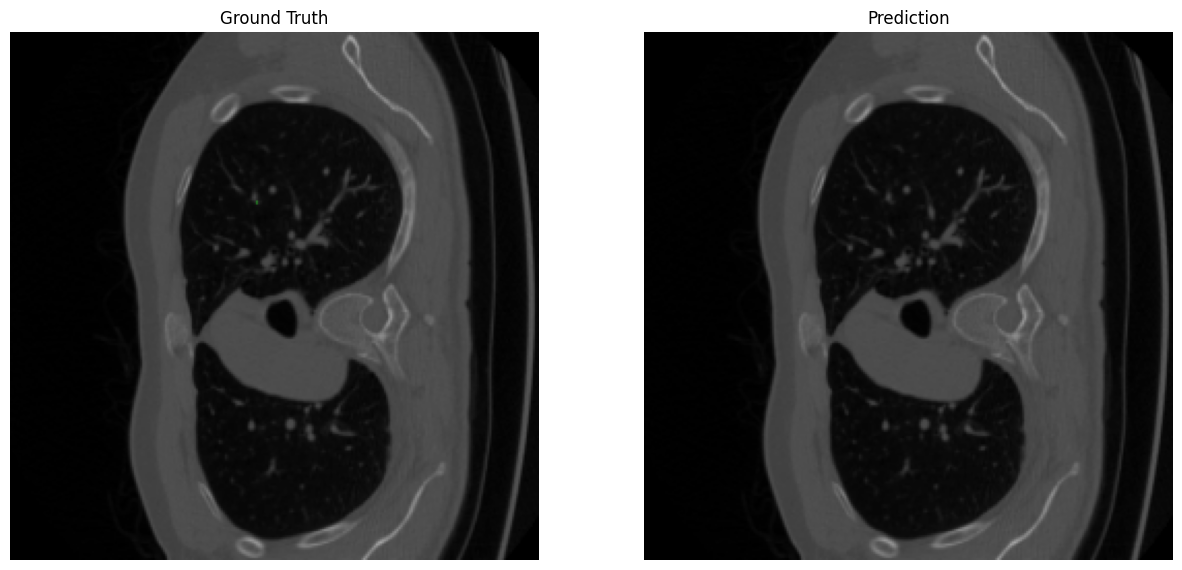

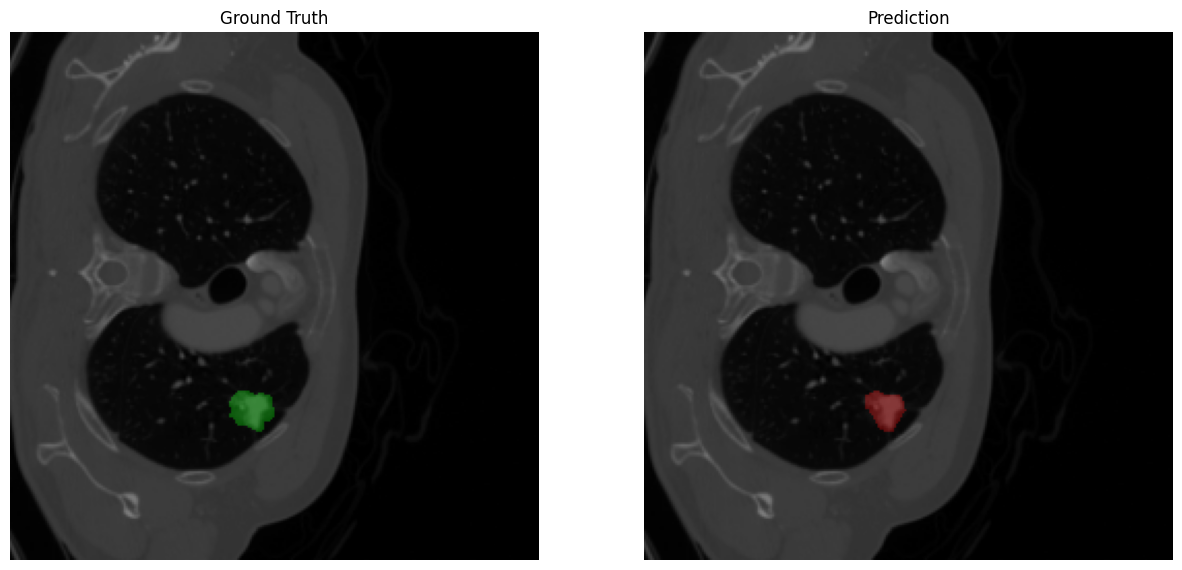

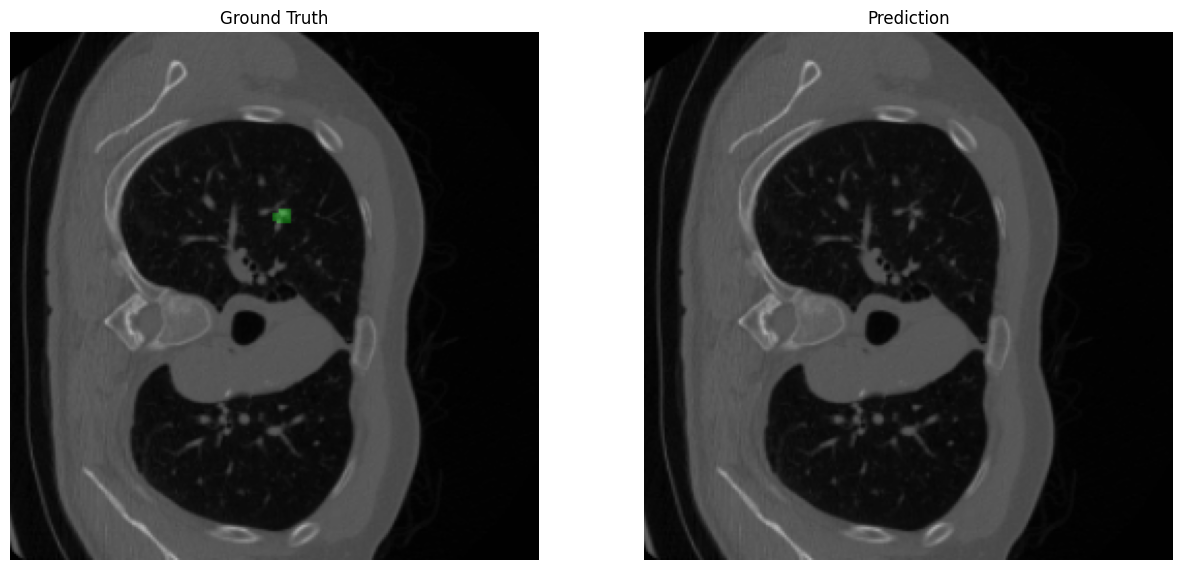

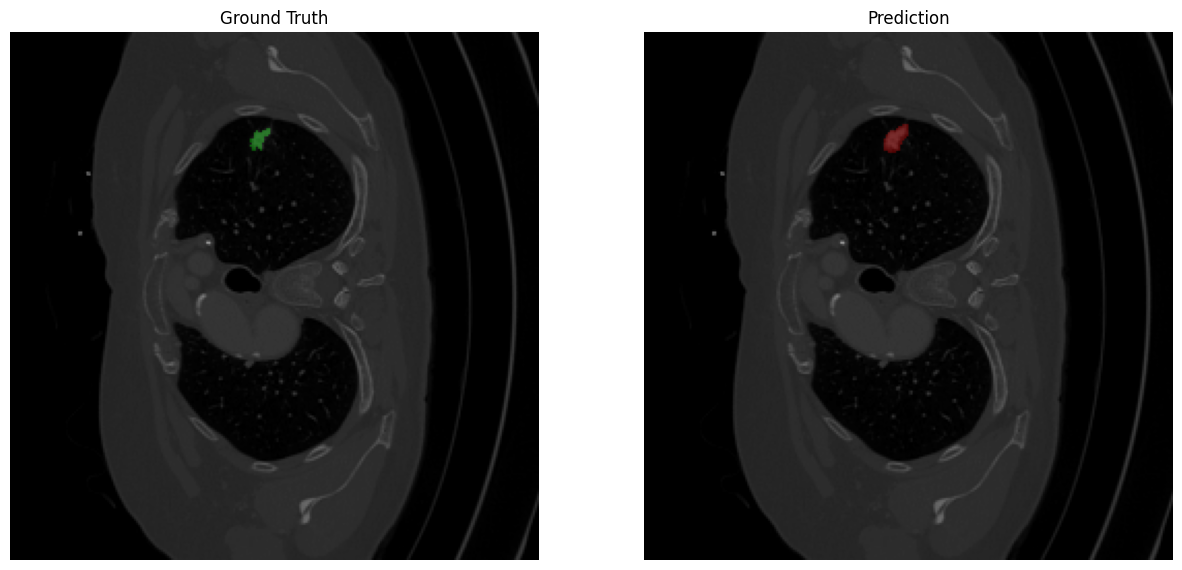

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()
images_shown = 0
max_images = 10

with torch.no_grad():
    for images, targets, _ in val_loader:
        images = list(img.to(device) for img in images)
        predictions = model(images)

        batch_size = len(images)
        for idx in range(batch_size):
            if images_shown >= max_images:
                break

            image = images[idx].cpu()
            image_np = image.permute(1, 2, 0).numpy()

            # Convert grayscale to RGB if needed
            if image_np.shape[2] == 1:
                image_np = np.repeat(image_np, 3, axis=2)
            # Scale pixels to [0,255] if in [0,1]
            if image_np.max() <= 1.0:
                image_np = (image_np * 255).astype(np.uint8)

            pred = predictions[idx]
            gt_masks = targets[idx]['masks'].cpu()  # Ground truth masks, shape: [num_objects, H, W]

            # Create a figure with 2 subplots
            fig, axes = plt.subplots(1, 2, figsize=(15, 8))

            # ---- Plot Ground Truth ----
            axes[0].imshow(image_np)
            axes[0].set_title("Ground Truth")
            axes[0].axis('off')

            # Overlay all GT masks in green (alpha=0.5)
            gt_mask_overlay = np.zeros_like(image_np)
            for m in range(gt_masks.shape[0]):
                mask = gt_masks[m].numpy() > 0.5
                gt_mask_overlay[mask] = [0, 255, 0]  # Green

            blended_gt = (0.7 * image_np + 0.3 * gt_mask_overlay).astype(np.uint8)
            axes[0].imshow(blended_gt)

            # ---- Plot Prediction ----
            axes[1].imshow(image_np)
            axes[1].set_title("Prediction")
            axes[1].axis('off')

            pred_mask_overlay = np.zeros_like(image_np)
            for i in range(len(pred['masks'])):
                score = pred['scores'][i].item()
                if score < 0.5:
                    continue

                mask = pred['masks'][i, 0].cpu().numpy() > 0.5
                pred_mask_overlay[mask] = [255, 0, 0]  # Red

            blended_pred = (0.7 * image_np + 0.3 * pred_mask_overlay).astype(np.uint8)
            axes[1].imshow(blended_pred)

            plt.show()

            images_shown += 1

        if images_shown >= max_images:
            break
